# Scotland’s Monthly Birth-Rate Forecasting

## Import Libraries

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.layers import LSTM, Dense, Dropout, InputLayer, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tcn import TCN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings('ignore')

## Load Dataset

In [37]:
df = pd.read_excel('dataset.xlsx')
df.head()

,Table 1: Monthly birth registrations in Scotland by NHS Board area [note 1][note 2][note 3][note 4][note 6],Unnamed: 1,Unnamed: 2,Unnamed: 3
0,Births by month of registration and NHS Board ...,NaN,NaN,NaN
1,This worksheet contains one table.,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,Year,Month,NHS Board area,Births registered
4,2025,June,Ayrshire and Arran,273


## Data Preprocessing

In [38]:
df.columns = ['Year', 'Month', 'NHS_Board', 'Births']

In [39]:
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')  

df_filtered = df[(df['Year'] >= 1998) & (df['Year'] <= 2022)]

In [40]:
df_scotland = df_filtered[df_filtered['NHS_Board'] == 'Scotland']

In [41]:
df_scotland.reset_index(drop=True, inplace=True)

In [42]:
df_scotland.info()
df_scotland.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Year       300 non-null    float64
 1   Month      300 non-null    object 
 2   NHS_Board  300 non-null    object 
 3   Births     300 non-null    object 
dtypes: float64(1), object(3)
memory usage: 9.5+ KB


,Year
count,300.000000
mean,2010.000000
std,7.223151
min,1998.000000
25%,2004.000000
50%,2010.000000
75%,2016.000000
max,2022.000000


In [43]:
df_scotland.isnull().sum()

Year         0
Month        0
NHS_Board    0
Births       0
dtype: int64

In [44]:
df_scotland['Year'] = df_scotland['Year'].astype(int)

df_scotland['Date'] = pd.to_datetime(df_scotland['Month'] + ' ' + df_scotland['Year'].astype(str), format='%B %Y')

In [45]:
df_scotland['Births'] = df_scotland['Births'].astype(int)

In [46]:
df = df_scotland.copy()

In [74]:
df_scotland.to_excel("clean_dataset.xlsx", index=False)

## Exploratory Data Analysis

**Full Monthly Birth Trend (1998–2022)**

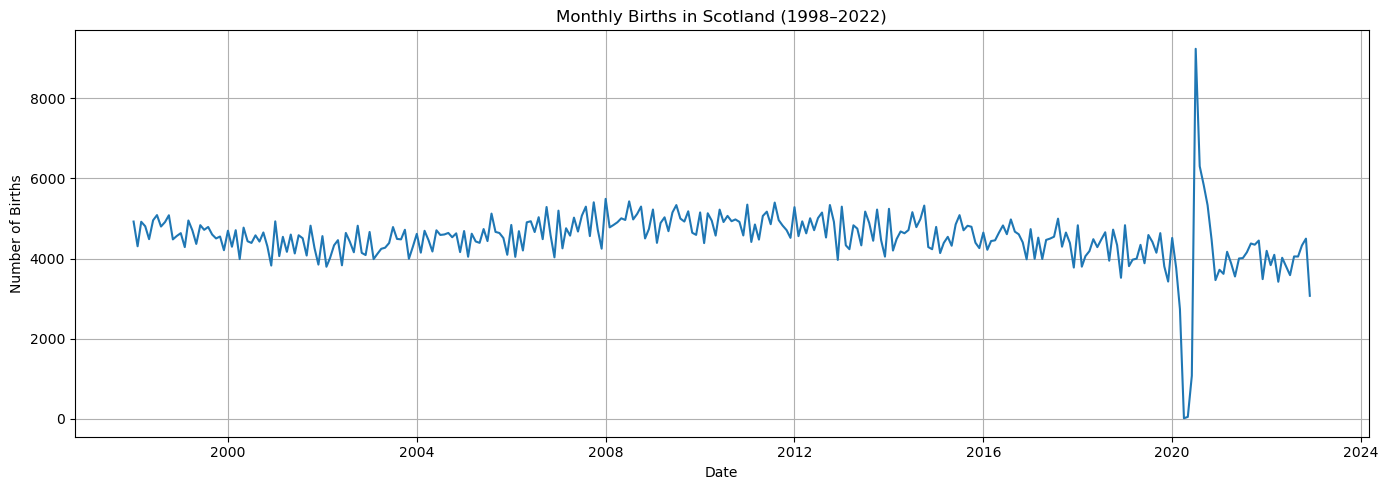

In [47]:
plt.figure(figsize=(14, 5))
sns.lineplot(data=df, x='Date', y='Births')
plt.title("Monthly Births in Scotland (1998–2022)")
plt.xlabel("Date")
plt.ylabel("Number of Births")
plt.grid(True)
plt.tight_layout()
plt.show()

**Seasonality – Average Monthly Births Across Years**

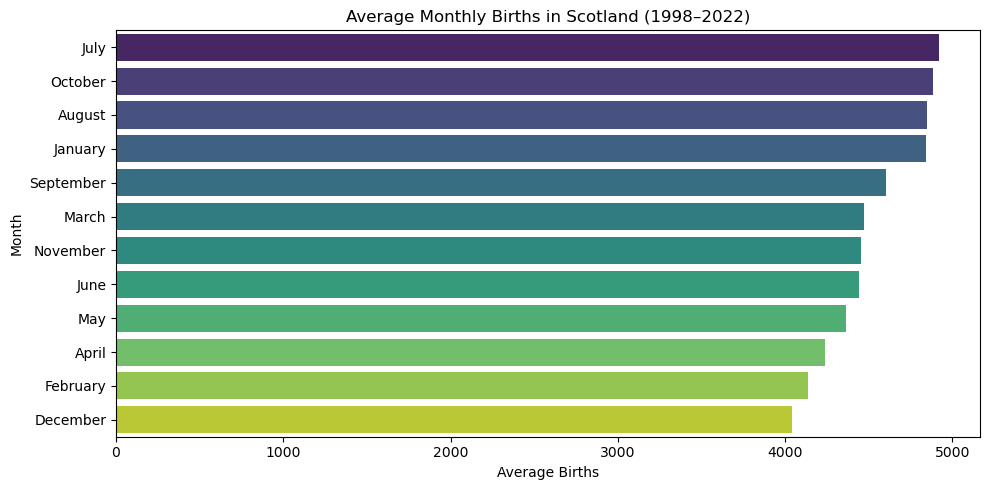

In [48]:
# Calculate average births per month
monthly_avg = df.groupby('Month')['Births'].mean().reindex([
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'])

monthly_avg_sorted = monthly_avg.sort_values(ascending=False)

# Plotting
plt.figure(figsize=(10, 5))
sns.barplot(y=monthly_avg_sorted.index, x=monthly_avg_sorted.values, palette='viridis', orient='h')
plt.title("Average Monthly Births in Scotland (1998–2022)")
plt.xlabel("Average Births")
plt.ylabel("Month")
plt.tight_layout()
plt.show()

**Add Date-Based Features**

In [49]:
df = df.sort_values('Date').set_index('Date')

In [50]:
df['Month_Num'] = df.index.month
df['Quarter'] = df.index.quarter

# Log transform the target
df['Births'] = np.log1p(df['Births']) 

# lag features on the transformed series
df['Births_lag1'] = df['Births'].shift(1)
df['Births_lag12'] = df['Births'].shift(12)

## Basline Models

In [51]:
# SMAPE
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

# Plotting helper
def plot_forecast(y_train, y_test, y_pred, title='Forecast'):
    plt.figure(figsize=(12, 6))
    
    # Build timeline
    all_index = list(y_train.index) + list(y_test.index)
    
    # Plot
    plt.plot(y_train.index, y_train, label='Train', color='blue')
    plt.plot(y_test.index, y_test, label='Test', color='green')
    plt.plot(y_test.index, y_pred, label='Forecast', color='orange')
    
    plt.title(title)
    plt.xlabel('Year')
    plt.ylabel('Monthly Births')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Evaluation helper
def evaluate(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    s = smape(y_true, y_pred)
    print(f"\n{model_name} Results")
    print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, SMAPE: {s:.2f}%")
    return mae, rmse, s

**Train test Split**

In [52]:
# Split by date
train = df['1998':'2018']
val = df['2019':'2020']
test = df['2021':'2022']

print(f"Train size: {len(train)}, Val size: {len(val)}, Test size: {len(test)}")

df['log_births'] = np.log(df['Births'])

Train size: 252, Val size: 24, Test size: 24


--------------

### SARIMA Model

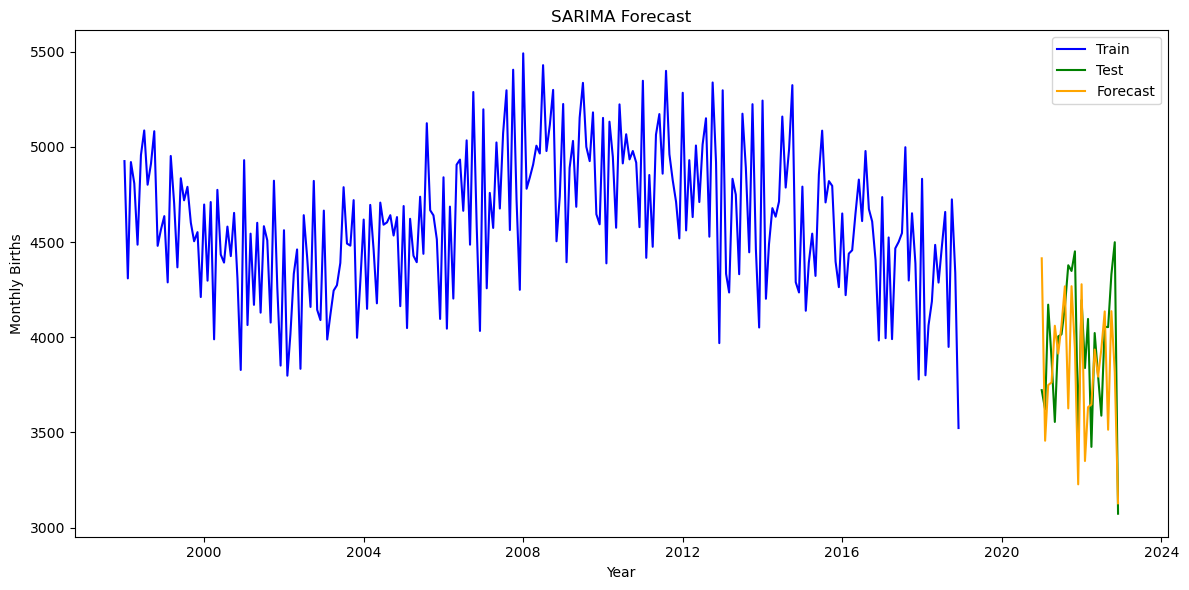

                                      SARIMAX Results                                      
Dep. Variable:                              Births   No. Observations:                  252
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 12)   Log Likelihood                 349.079
Date:                             Fri, 01 Aug 2025   AIC                           -690.158
Time:                                     18:21:07   BIC                           -676.476
Sample:                                 01-01-1998   HQIC                          -684.637
                                      - 12-01-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3285      0.070     -4.673      0.000      -0.466      -0.191
ma.L1         -0.8699      

(292.20755950786724,
 np.float64(372.3177038380116),
 np.float64(7.500644634617287))

In [53]:
sarima_model = sm.tsa.SARIMAX(train['Births'], order=(1,1,1), seasonal_order=(1,1,0,12), 
                              enforce_stationarity=False, enforce_invertibility=False)
sarima_results = sarima_model.fit()

sarima_forecast_log = sarima_results.predict(start=test.index[0], end=test.index[-1], dynamic=False)
sarima_forecast = np.exp(sarima_forecast_log)

plot_forecast(np.exp(train['Births']), np.exp(test['Births']), sarima_forecast, 'SARIMA Forecast')
print(sarima_results.summary())
evaluate(np.exp(test['Births']), sarima_forecast, "SARIMA")


----------

### ARIMA Model

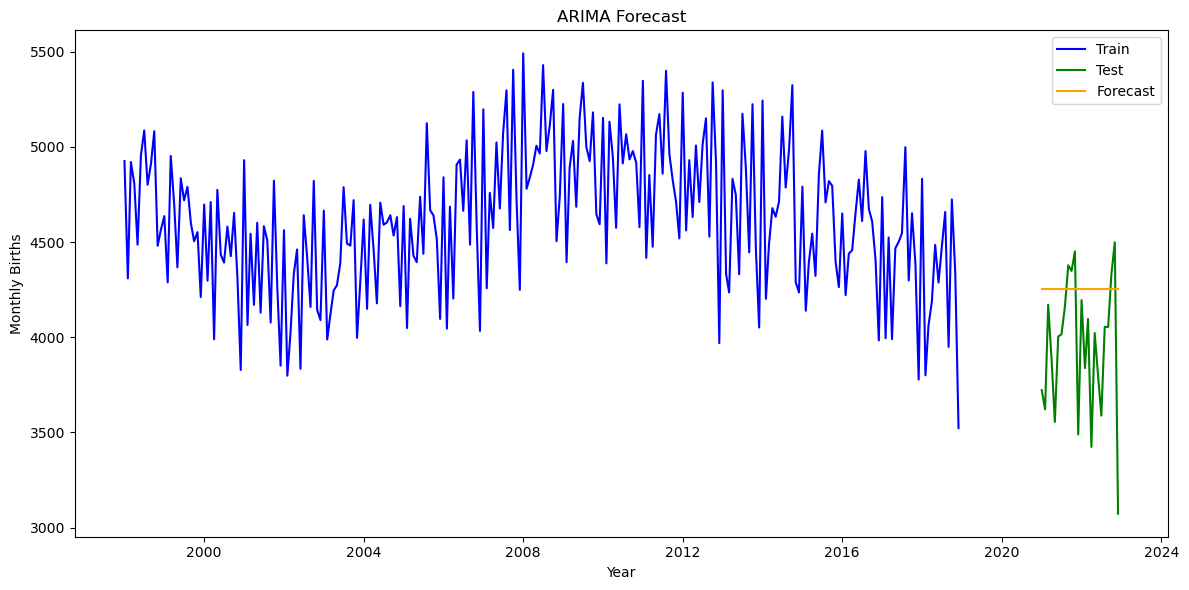

                               SARIMAX Results                                
Dep. Variable:                 Births   No. Observations:                  252
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 310.431
Date:                Fri, 01 Aug 2025   AIC                           -614.862
Time:                        18:21:09   BIC                           -604.286
Sample:                    01-01-1998   HQIC                          -610.606
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2900      0.070     -4.161      0.000      -0.427      -0.153
ma.L1         -0.8460      0.038    -22.145      0.000      -0.921      -0.771
sigma2         0.0049      0.000     10.931      0.0

(367.44722731714745,
 np.float64(467.67331781307274),
 np.float64(9.27050584683352))

In [54]:
arima_model = sm.tsa.ARIMA(train['Births'], order=(1, 1, 1))
arima_results = arima_model.fit()

arima_forecast_log = arima_results.predict(start=test.index[0], end=test.index[-1], dynamic=False)
arima_forecast = np.exp(arima_forecast_log)

plot_forecast(np.exp(train['Births']), np.exp(test['Births']), arima_forecast, 'ARIMA Forecast')
print(arima_results.summary())
evaluate(np.exp(test['Births']), arima_forecast, "ARIMA")


----------

### XgBoost Model

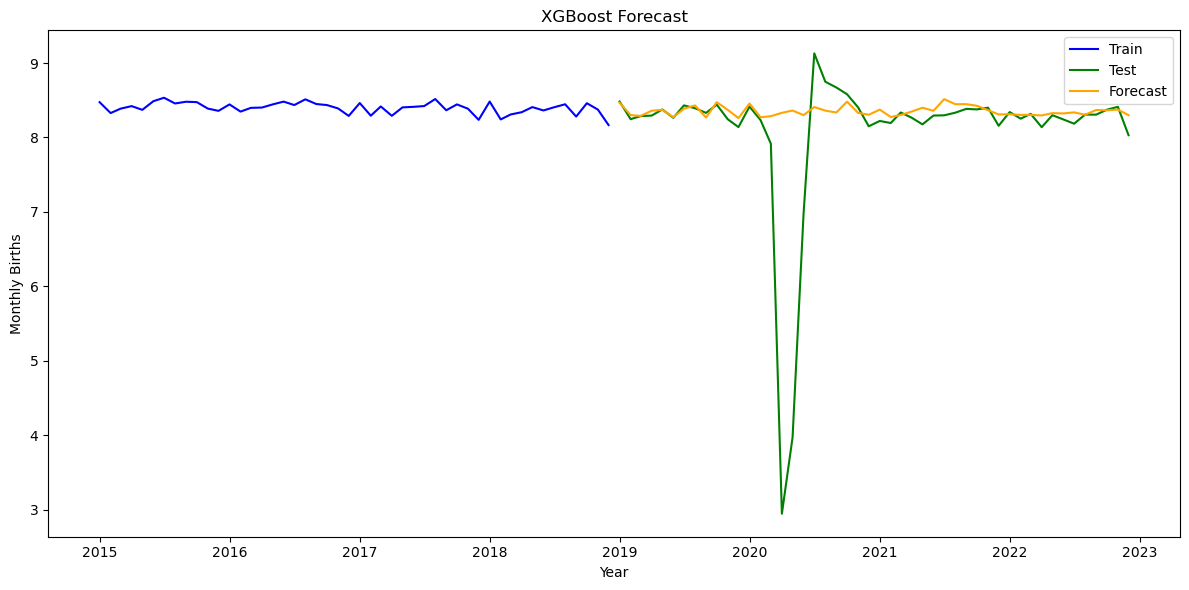

XGBoost - MAE: 0.33, RMSE: 1.03, SMAPE: 5.07


In [55]:
def create_lag_features(df, lags=12):
    df_lagged = pd.DataFrame()
    df_lagged['target'] = df['log_births']
    for lag in range(1, lags + 1):
        df_lagged[f'lag_{lag}'] = df['log_births'].shift(lag)
    return df_lagged.dropna()

lagged_df = create_lag_features(df, lags=12)
lagged_df.index = df.index[12:] 

# Split into Train/Test
n_train = len(train)
train_lagged = lagged_df.iloc[:n_train - 12] 
test_lagged = lagged_df.iloc[n_train - 12:]  

X_train = train_lagged.drop('target', axis=1)
y_train = train_lagged['target']
X_test = test_lagged.drop('target', axis=1)
y_test = test_lagged['target']

# Fit XGBoost Model 
xgb_model = XGBRegressor(n_estimators=100,learning_rate=0.1,max_depth=3, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict and Inverse Log 
y_pred_log = xgb_model.predict(X_test)
y_pred = np.exp(y_pred_log)
y_test_actual = np.exp(y_test)
y_train_recent = np.exp(y_train.iloc[-len(y_test):])

recent_train_log = y_train.iloc[-len(y_test):]
recent_train = np.exp(recent_train_log)

# Plot Forecast 
plot_forecast(y_train=y_train_recent,     y_test=y_test_actual,      y_pred=y_pred,             title='XGBoost Forecast')

# Evaluate Metrics
def evaluate(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    smape = 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))
    print(f"{model_name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, SMAPE: {smape:.2f}")
    return mae, rmse, smape

xgb_mae, xgb_rmse, xgb_smape = evaluate(y_test_actual, y_pred, "XGBoost")

In [56]:
results_df = pd.DataFrame(columns=['Model', 'MAE', 'RMSE', 'SMAPE'])

for model_name, y_true, y_pred in [
    ('SARIMA', np.exp(test['Births']), sarima_forecast),
    ('ARIMA', np.exp(test['Births']), arima_forecast),
    ('XGBoost', y_test_actual, y_pred)]:
    mae, rmse, smape_val = evaluate(y_true, y_pred, model_name)
    results_df.loc[len(results_df)] = [model_name, mae, rmse, smape_val]

print(results_df)

SARIMA - MAE: 292.21, RMSE: 372.32, SMAPE: 7.50
ARIMA - MAE: 367.45, RMSE: 467.67, SMAPE: 9.27
XGBoost - MAE: 0.33, RMSE: 1.03, SMAPE: 5.07
     Model         MAE        RMSE     SMAPE
0   SARIMA  292.207560  372.317704  7.500645
1    ARIMA  367.447227  467.673318  9.270506
2  XGBoost    0.334454    1.034545  5.065344


---------

### LSTM & Bidirectional LSTM Model

In [57]:
scaler = MinMaxScaler()
births_scaled = scaler.fit_transform(df[['Births']])

def create_sequences(data, window_size=12):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i - window_size:i])
        y.append(data[i])
    return np.array(X), np.array(y)

window_size = 12
X, y = create_sequences(births_scaled, window_size)

# Reshape for LSTM: (samples, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split into train/validation
split = int(len(X) * 0.7)
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

In [58]:
# Build LSTM Model
def build_lstm_model(input_shape):
    lstm_model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(64),
        Dropout(0.2),
        Dense(1)])
    lstm_model.compile(optimizer='adam', loss=MeanSquaredError())
    return lstm_model

# Build Bidirectional LSTM Model
def build_bilstm_model(input_shape):
    bilstm_model = Sequential([
        Bidirectional(LSTM(64, return_sequences=True), input_shape=input_shape),
        Dropout(0.1),
        Bidirectional(LSTM(64)),
        Dropout(0.1),
        Dense(1)])
    bilstm_model.compile(optimizer='adam', loss=MeanSquaredError())
    return bilstm_model

In [59]:
# Train Model
def train_model(model, X_train, y_train, X_val, y_val):
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=8,
        callbacks=[early_stop],
        verbose=1)
    return model, history

In [60]:
# Evaluate and Plot
def evaluate_and_plot(model, X_val, y_val, title):
    # Predict
    y_pred = model.predict(X_val)

    # Invert scale and log1p
    y_val_inv = np.expm1(scaler.inverse_transform(y_val))
    y_pred_inv = np.expm1(scaler.inverse_transform(y_pred))

    mae = mean_absolute_error(y_val_inv, y_pred_inv)
    rmse = np.sqrt(mean_squared_error(y_val_inv, y_pred_inv))
    smape = 100 * np.mean(2 * np.abs(y_val_inv - y_pred_inv) / (np.abs(y_val_inv) + np.abs(y_pred_inv)))

    print(f"{title} Evaluation")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"SMAPE: {smape:.2f}%")

   # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(y_val_inv, label='Actual')
    plt.plot(y_pred_inv, label='Predicted')
    plt.title(f"{title} – Scotland Birth Forecast")
    plt.xlabel("Months")  
    plt.ylabel("Number of Births")           
    plt.legend()
    plt.show()

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.3042 - val_loss: 0.0326
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0139 - val_loss: 0.0177
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0070 - val_loss: 0.0168
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0063 - val_loss: 0.0168
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0060 - val_loss: 0.0168
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0060 - val_loss: 0.0168
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0065 - val_loss: 0.0169
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0066 - val_loss: 0.0177
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0056 - val_loss: 0.0169
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0054 - val_loss: 0.0168
Epoch 11/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0061 - val_loss: 0.0190
Epoch 12/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

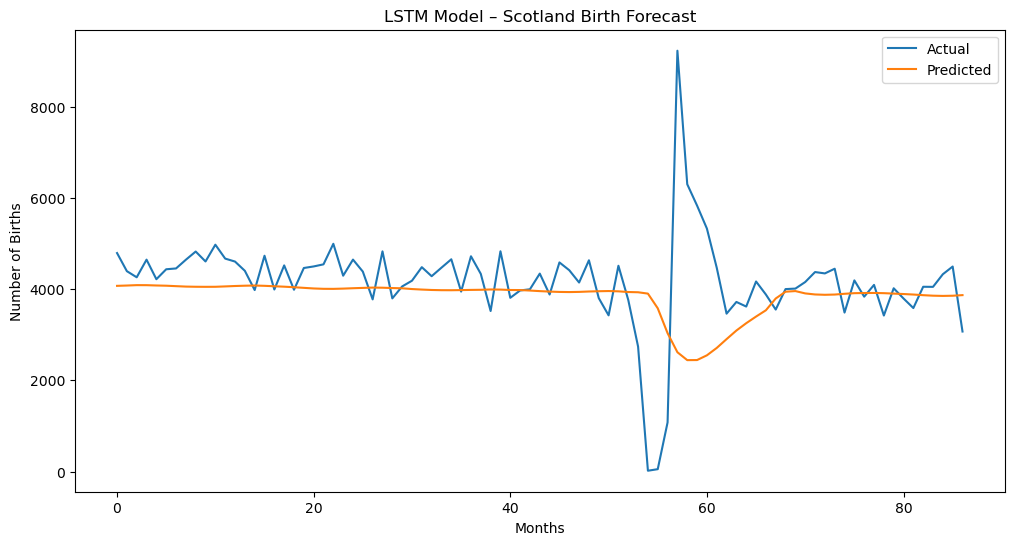

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - loss: 0.1672 - val_loss: 0.0230
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0054 - val_loss: 0.0169
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0025 - val_loss: 0.0162
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0024 - val_loss: 0.0163
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0019 - val_loss: 0.0162
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0015 - val_loss: 0.0165
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0017 - val_loss: 0.0167
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0018 - val_loss: 0.0162
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0024 - val_loss: 0.0174
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0017 - val_loss: 0.0161
Epoch 11/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0017 - val_loss: 0.0163
Epoch 12/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

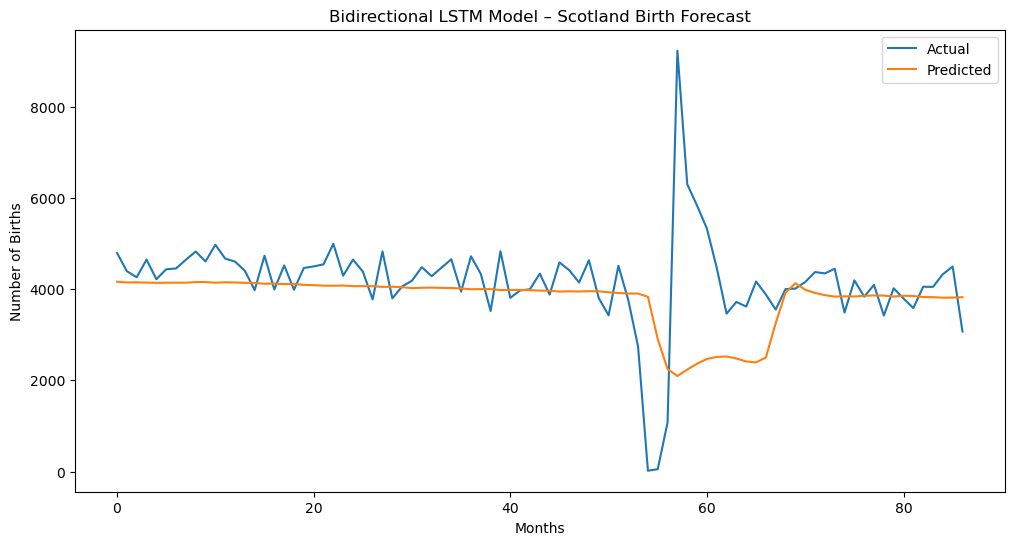

In [61]:
# Run LSTM Model
lstm_model = build_lstm_model((window_size, 1))
lstm_model, _ = train_model(lstm_model, X_train, y_train, X_val, y_val)
evaluate_and_plot(lstm_model, X_val, y_val, "LSTM Model")

# Run Bidirectional LSTM Model
bilstm_model = build_bilstm_model((window_size, 1))
bilstm_model, _ = train_model(bilstm_model, X_train, y_train, X_val, y_val)
evaluate_and_plot(bilstm_model, X_val, y_val, "Bidirectional LSTM Model")

----------

### TCN

In [62]:
window_size = X_train.shape[1]  
n_features = X_train.shape[2]   

model = Sequential([
    InputLayer(input_shape=(window_size, n_features)),
    TCN(nb_filters=64, kernel_size=3, dilations=[1, 2, 4, 8, 16, 32], dropout_rate=0.1, return_sequences=True),
    TCN(nb_filters=32, kernel_size=3, dilations=[1, 2, 4], dropout_rate=0.1, return_sequences=False),
    Dense(1)])

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tcn_2 (TCN)                     │ (None, 12, 64)         │       136,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tcn_3 (TCN)                     │ (None, 32)             │        23,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,065 (625.25 KB)

 Trainable params: 160,065 (625.25 KB)

 Non-trainable params: 0 (0.00 B)

In [63]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train,validation_data=(X_val, y_val),epochs=100,batch_size=8,callbacks=[early_stop],verbose=1)

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - loss: 99.4689 - val_loss: 0.9661
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 2.6543 - val_loss: 0.1597
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.9770 - val_loss: 0.0443
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.6625 - val_loss: 0.0628
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.5195 - val_loss: 0.0615
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.3914 - val_loss: 0.0470
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.3021 - val_loss: 0.0671
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.3369 - val_loss: 0.1198
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.2445 - val_loss: 0.1744
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.2109 - val_loss: 0.0828
Epoch 11/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.1848 - val_loss: 0.0507
Epoch 12/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/st

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 310ms/step
MAE: 0.73
RMSE: 1.30
SMAPE: 9.24%


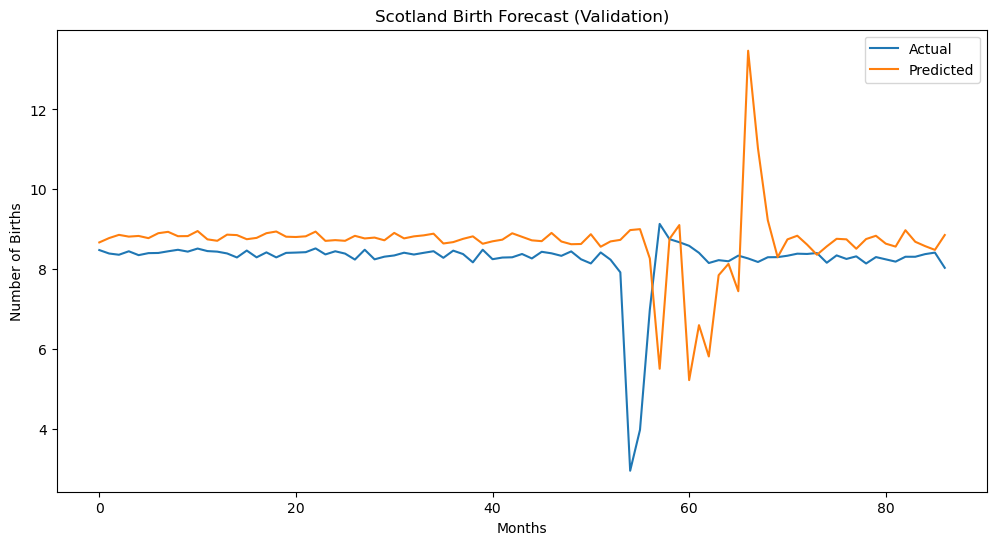

In [64]:
y_pred = model.predict(X_val)

y_val_reshaped = y_val.reshape(-1, 1)
y_val_inv = scaler.inverse_transform(y_val_reshaped).flatten()
y_pred_inv = scaler.inverse_transform(y_pred).flatten()

# Metrics
mae = mean_absolute_error(y_val_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_val_inv, y_pred_inv))
smape = 100 * np.mean(2 * np.abs(y_val_inv - y_pred_inv) / (np.abs(y_val_inv) + np.abs(y_pred_inv)))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"SMAPE: {smape:.2f}%")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(y_val_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.title(f"Scotland Birth Forecast (Validation)")
plt.xlabel("Months")
plt.ylabel("Number of Births")
plt.legend()
plt.show()

---------

### Time Series Transformer

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - loss: 0.7706 - val_loss: 0.6701
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6942 - val_loss: 0.5973
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6157 - val_loss: 0.5271
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5454 - val_loss: 0.4600
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4742 - val_loss: 0.3967
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4083 - val_loss: 0.3377
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3476 - val_loss: 0.2835
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2926 - val_loss: 0.2347
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2405 - val_loss: 0.1914
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1944 - val_loss: 0.1537
Epoch 11/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1555 - val_loss: 0.1216
Epoch 12/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

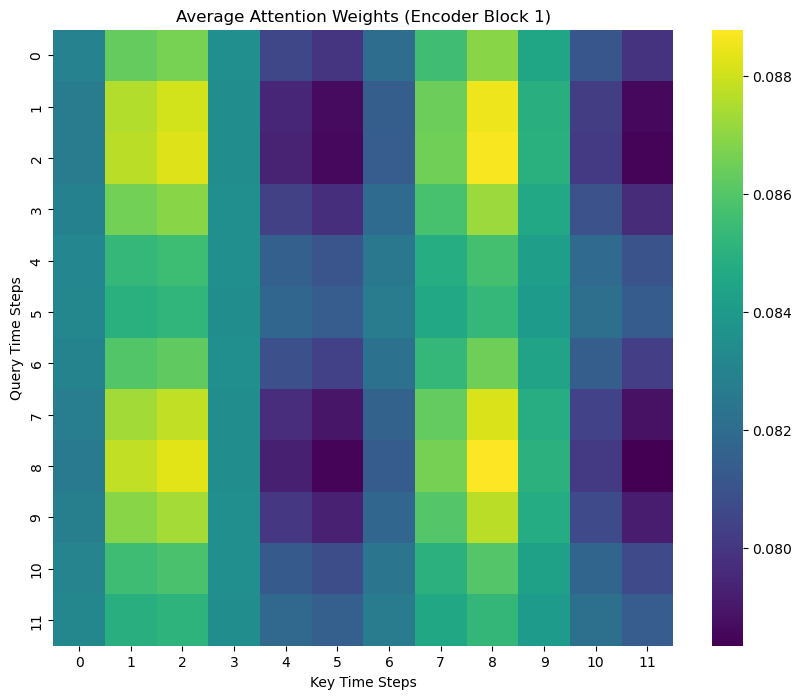

In [79]:
# --- Positional Encoding ---
def positional_encoding(seq_len, d_model):
    angle_rads = np.arange(seq_len)[:, np.newaxis] / np.power(
        10000, (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / np.float32(d_model)
    )
    pos_encoding = np.zeros_like(angle_rads)
    pos_encoding[:, 0::2] = np.sin(angle_rads[:, 0::2])
    pos_encoding[:, 1::2] = np.cos(angle_rads[:, 1::2])
    return tf.cast(pos_encoding[np.newaxis, ...], dtype=tf.float32)


# --- Transformer Encoder ---
def transformer_encoder(inputs, head_size=64, num_heads=2, ff_dim=128, dropout=0.1, return_attention=False):
    attn_layer = layers.MultiHeadAttention(num_heads=num_heads, key_dim=head_size)
    attn_output, attn_weights = attn_layer(inputs, inputs, return_attention_scores=True)
    x = layers.Dropout(dropout)(attn_output)
    x = layers.LayerNormalization(epsilon=1e-6)(x + inputs)

    ff_output = layers.Dense(ff_dim, activation="relu")(x)
    ff_output = layers.Dense(inputs.shape[-1])(ff_output)
    x = layers.Dropout(dropout)(ff_output)
    x = layers.LayerNormalization(epsilon=1e-6)(x + ff_output)

    if return_attention:
        return x, attn_weights
    return x


# --- Build Transformer with Attention Access ---
def build_transformer_model(input_shape, num_layers=2, head_size=64, num_heads=2, ff_dim=128, dropout=0.1):
    inputs = tf.keras.Input(shape=input_shape)
    pos_enc = positional_encoding(input_shape[0], input_shape[1])
    x = inputs + pos_enc

    attn_weights_list = []
    attn_outputs = []

    for i in range(num_layers):
        x, attn_weights = transformer_encoder(x, head_size, num_heads, ff_dim, dropout, return_attention=True)
        attn_weights_list.append(attn_weights)
        attn_outputs.append(x)

    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(1)(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss=MeanSquaredError())

    # Attention model for visualization
    attention_model = tf.keras.Model(inputs=inputs, outputs=attn_weights_list)

    return model, attention_model


# --- Instantiate Models ---
input_shape = (X_train.shape[1], X_train.shape[2])
transformer_model, attention_model = build_transformer_model(input_shape)

# --- Training ---
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = transformer_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=8,
    callbacks=[early_stop],
    verbose=1
)

# --- Attention Visualization ---
sample_input = np.expand_dims(np.array(X_test)[0], axis=0)
attn_scores = attention_model.predict(sample_input)  # List of tensors from each encoder block

# Visualize attention from first encoder block
attention = attn_scores[0][0]  # shape: (num_heads, seq_len, seq_len)
avg_attention = np.mean(attention, axis=0)

plt.figure(figsize=(10, 8))
sns.heatmap(avg_attention, cmap="viridis", xticklabels=True, yticklabels=True)
plt.title("Average Attention Weights (Encoder Block 1)")
plt.xlabel("Key Time Steps")
plt.ylabel("Query Time Steps")
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Time-Series Transformer Evaluation
MAE: 770.33
RMSE: 1137.99
SMAPE: 21.12%


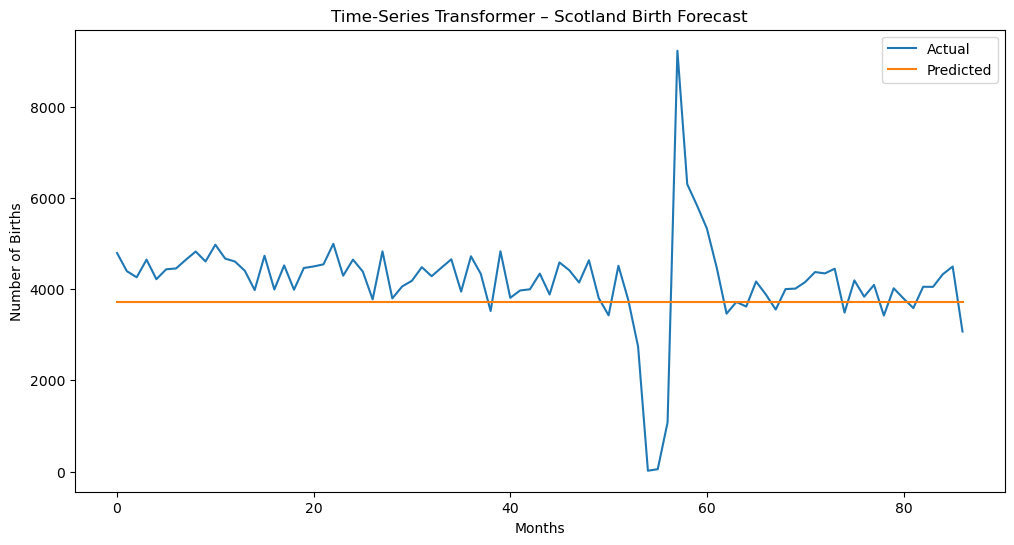

In [81]:
evaluate_and_plot(transformer_model, X_val, y_val, "Time-Series Transformer")

In [ ]:
# Save model to disk
lstm_model.save("lstm_model.h5")
bilstm_model.save("bilstm_model.h5")

In [ ]:
# After training
transformer_model.save("transformer_model.keras")